In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [2]:
def get_kraken_data(symbol):
    filename = 'Kraken_OHLCVT/{}USD_1.csv'.format(symbol.replace('BTC', 'XBT'))
    if not os.path.exists(filename):
        return pd.DataFrame()
    df = pd.read_csv(
        filename,
        names=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume', 'trades']
    )
    
    df['timestamp_5m'] = (df['timestamp'] // 300) * 300
    df['timestamp_1h'] = (df['timestamp'] // 3600) * 3600

    df_5m = pd.concat([
        df.groupby('timestamp_5m')['cl'].nth(-1),
    ], axis=1)
    df_5m = df_5m.reset_index()
    df_5m['timestamp_1h'] = (df_5m['timestamp_5m'] // 3600) * 3600
    
    df = pd.concat([
        df.groupby('timestamp_1h')['op'].nth(0),
        df.groupby('timestamp_1h')['hi'].max(),
        df.groupby('timestamp_1h')['lo'].min(),
        df.groupby('timestamp_1h')['cl'].nth(-1),
        df.groupby('timestamp_1h')['volume'].sum(),
        df.groupby('timestamp_1h')['trades'].sum(),
        df_5m.groupby('timestamp_1h')['cl'].mean().rename('twap_5m'),
    ], axis=1)
    
    df.index.rename('timestamp', inplace=True)
    
    df['symbol'] = symbol
    df = df.reset_index()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df = df.set_index(['timestamp', 'symbol'])
    return df

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    dfs = list(map(get_kraken_data, symbols))
    df = df.copy()
    df['extended'] = False
    df = pd.concat([df] + dfs)
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    # df = df.loc[df.index.drop_duplicates()]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()
    
display(get_kraken_data('BTC'))

,,op,hi,lo,cl,volume,trades,twap_5m
timestamp,symbol,,,,,,,
2013-10-06 21:00:00+00:00,BTC,122.00000,122.00000,122.00,122.00,0.100000,1,122.000000
2013-10-07 20:00:00+00:00,BTC,123.61000,123.61000,123.61,123.61,0.100000,1,123.610000
2013-10-08 02:00:00+00:00,BTC,123.91000,123.91000,123.90,123.90,1.991600,2,123.900000
2013-10-08 05:00:00+00:00,BTC,124.19000,124.19000,124.18,124.18,2.000000,2,124.180000
2013-10-09 09:00:00+00:00,BTC,124.01687,124.01687,123.84,123.84,2.823000,3,123.840000
...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00+00:00,BTC,18949.70000,19000.00000,18841.00,18883.90,212.169331,1651,18924.191667
2022-06-30 20:00:00+00:00,BTC,18896.80000,19041.50000,18617.50,18732.30,343.422628,1832,18880.508333
2022-06-30 21:00:00+00:00,BTC,18731.60000,18931.20000,18694.80,18796.60,300.613095,1209,18848.266667


In [3]:
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC']

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)
df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2020-10-29 06:00:00+00:00,ADAUSDT,0.10008,0.10017,0.09963,0.09981,10969098.0,1.095526e+06,4515.0,5102617.0,...,0.099827,0.099816,0.000142,0.000062,0.099872,0.099787,0.000039,-0.000047,0.000853,9.458891e-07
1,2020-11-16 11:00:00+00:00,ADAUSDT,0.10301,0.10315,0.10238,0.10241,9364947.0,9.630226e+05,4866.0,4743491.0,...,0.102854,0.102832,0.000137,0.000075,0.102920,0.102804,0.000057,-0.000058,0.001125,1.536971e-06
2,2020-11-15 11:00:00+00:00,ADAUSDT,0.10314,0.10371,0.10263,0.10266,13117924.0,1.353000e+06,5305.0,6854920.0,...,0.103153,0.103172,0.000251,0.000090,0.103217,0.103105,0.000057,-0.000055,0.001081,1.504847e-06
3,2020-11-16 02:00:00+00:00,ADAUSDT,0.10013,0.10062,0.09967,0.10016,11115604.0,1.112733e+06,4428.0,5430827.0,...,0.100150,0.100116,0.000235,0.000102,0.100219,0.100095,0.000071,-0.000054,0.001240,1.886836e-06
4,2020-11-15 06:00:00+00:00,ADAUSDT,0.10437,0.10510,0.10430,0.10480,8020046.0,8.400803e+05,4385.0,5095373.0,...,0.104652,0.104661,0.000203,0.000077,0.104698,0.104610,0.000049,-0.000039,0.000844,1.025699e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234480,2022-03-02 17:00:00+00:00,MATICUSDT,1.65530,1.66740,1.63330,1.63530,8673007.0,1.433102e+07,29345.0,3995194.0,...,1.654248,1.653250,0.008710,0.002279,1.656182,1.652683,0.001563,-0.001935,0.002117,5.563870e-06
234481,2022-03-15 19:00:00+00:00,MATICUSDT,1.39280,1.40920,1.39040,1.39720,10476814.0,1.467104e+07,29848.0,5789143.0,...,1.399227,1.399058,0.003782,0.001833,1.400578,1.397905,0.001422,-0.001252,0.001910,4.260190e-06
234482,2022-03-08 14:00:00+00:00,MATICUSDT,1.45670,1.46720,1.44040,1.44720,15283799.0,2.221595e+07,42231.0,7554742.0,...,1.452727,1.452175,0.005306,0.003493,1.455335,1.450733,0.002475,-0.002127,0.003167,1.264309e-05
234483,2022-02-20 23:00:00+00:00,MATICUSDT,1.54070,1.54990,1.50650,1.51090,14043737.0,2.151575e+07,39717.0,6385606.0,...,1.528815,1.528275,0.010250,0.002810,1.530765,1.527123,0.001437,-0.002205,0.002381,7.132379e-06


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-19 18:00:00+00:00 ETH     1207.41000  1209.84000  1206.7000   
                          LINK       6.14200     6.16700     6.1250   
                          MATIC      0.86800     0.87280     0.8670   
                          SOL       12.68900    12.79400    12.6410   
                          XRP        0.38110     0.38240     0.3802   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-19 18:00:00+00:00 ETH     1207.1800  4.520612e+04  1207.670000   
                          LINK       6.1470  6.305927e+05     6.144750   
                          MATIC      0.8709  9.180037e+06     0.869358   
                          SOL       12.7620  6.939940e+05    12.724417   
                          XRP        0.3819  1.555862e+07     0.381392   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-19 18:00:00+00:00 ETH        False  
                          LINK       False  
                          MATIC      False  
                          SOL        False  
                          XRP        False  

[353163 rows x 7 columns]

In [19]:
# import xgboost as xgb

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e5)
        # self._model = lgb.LGBMRegressor(
        #     # boosting="rf",
        #     # bagging_freq=3,
        #     # bagging_fraction=0.5,
        #     # colsample_bytree=0.3,
        #     # reg_lambda=1e7,
        #     n_estimators=1000,
        #     learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = xgb.XGBRanker(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     # label_gain=np.arange(100),
        #     # lambdarank_truncation_level=max_labels,
        #     # max_depth=5,
        #     # colsample_bytree=0.5,
        #     # num_leaves=2**6-1,
        #     n_jobs=-1
        # )
        
        self._model = lgb.LGBMRanker(
            n_estimators=1000,
            learning_rate=0.001,
            objective="lambdarank",
            extra_trees=True,
            # label_gain=np.arange(100),
            # lambdarank_truncation_level=max_labels,
            # max_depth=5,
            # colsample_bytree=0.5,
            # num_leaves=2**6-1,
            subsample=0.5,
            subsample_freq=1,
            n_jobs=-1
        )
        
        self.max_data_sec = 7 * 24 * 60 * 60
        self.provider_configs = provider_configs
        self.merge_data = merge_data

    def fit(self, df):
        if False:
            df_random = pd.concat([df])
            df_random['cl_rate'] = (df_random['cl'] / df_random.groupby('symbol')['cl'].shift(1)).fillna(1)
            df_random = df_random.reset_index()
            df_random['timestamp'] += pd.to_timedelta(10 * 365, unit='D')
            t = df_random['timestamp'].unique()
            t_shuffle = np.random.permutation(t)
            t_map = {}
            for i in range(t.shape[0]):
                t_map[t[i]] = t_shuffle[i]
            df_random['timestamp'] = df_random['timestamp'].map(t_map)
            df_random = df_random.set_index(['timestamp', 'symbol'])
            df_random = df_random.sort_index()
            df_random['cl'] = df_random.groupby('symbol')['cl_rate'].transform(lambda x: x.cumprod())
            df_random = self._calc_features(df_random)
            df_random['ret_rank'] = 0.0
            df_random = df_random.dropna()
        
        df = self._calc_features(df)
        features = get_feature_columns(df)
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret']) - 0.5
        # df['ret_neg'] = -df['ret']
        # df['ret_rank_int'] = df.groupby('timestamp')['ret_neg'].rank(method='min')
        df['ret_rank_int'] = df.groupby('timestamp')['ret'].rank(method='min')
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        
        # df = pd.concat([df, df_random])
        group = df.groupby('timestamp')['cl'].count()
        self._model.fit(df[features], df['ret_rank_int'], group=group)
        # self._model.fit(df[features], df['ret_rank'])
        # self._model.fit(df[features], df['ret'])
        
        # y_pred = self._model.predict(df[features])
        
        # def projection_matrix(x):
            # return x @ np.linalg.pinv(x.T @ x) @ x.T
        
        # x = df[features].values
        # self._feature_coef = (np.linalg.pinv(x.T @ x) @ x.T @ y_pred).flatten()
        # print(self._feature_coef)
        
        return self
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['position'] = self._model.predict(df[features])
        
        # df['position'] = 0.0
        # for timestamp, df_timestamp in df.groupby('timestamp'):
            # df.loc[df_timestamp.index, 'position'] = self._model.predict(df.loc[df_timestamp.index, features])
        # df['position'] = np.sign(y_pred)
        
        # x = df[features].values
        # y_pred -= 0.5 * (x @ self._feature_coef.reshape(-1, 1)).flatten()
        
        df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        
        def adosc(x, timeperiod=None):
            return talib.ADOSC(df.loc[x.index, 'hi'], df.loc[x.index, 'lo'], x, df.loc[x.index, 'volume'], fastperiod=timeperiod, slowperiod=timeperiod * 3 + 1)
        
        def macdsignal(x, timeperiod=None):
            return talib.MACDEXT(x, fastperiod=int(timeperiod * 1.3), slowperiod=timeperiod * 3, signalperiod=i)[1]
        
        def adx(x, timeperiod=None):
            return talib.ADX(df.loc[x.index, 'hi'], df.loc[x.index, 'lo'], x, timeperiod=timeperiod)
        
        def adxr(x, timeperiod=None):
            return talib.ADXR(df.loc[x.index, 'hi'], df.loc[x.index, 'lo'], x, timeperiod=timeperiod)
        
        def mfi(x, timeperiod=None):
            return talib.MFI(df.loc[x.index, 'hi'], df.loc[x.index, 'lo'], x, df.loc[x.index, 'volume'], timeperiod=timeperiod)
        
        df['ln_cl'] = np.log(df['cl'])
        df['ln_volume'] = np.log(df['volume'] + 1)
        
        
        for i in [8, 24, 48, 72]:
            df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
            # df['feature_hi_{}'.format(i)] = np.log(df.groupby('symbol')['hi'].transform(lambda x: x.rolling(i, 1).max())) - df['ln_cl']
            # df['feature_lo_{}'.format(i)] = np.log(df.groupby('symbol')['lo'].transform(lambda x: x.rolling(i, 1).min())) - df['ln_cl']
        
        for i in [8, 24, 48, 72]:
            df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            # df['feature_volume_rsi_{}'.format(i)] = df.groupby('symbol')['ln_volume'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))
            # df['feature_natr_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.NATR(df.loc[x.index, 'hi'], df.loc[x.index, 'lo'], x, timeperiod=i)).fillna(0)
            # df['feature_std_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: x.rolling(i, 1).std()).fillna(0)
        
            if i <= 24:
            #     # df['feature_adosc_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: adosc(x, timeperiod=i)).fillna(0)
                df['feature_macdsignal_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: macdsignal(x, timeperiod=i)).fillna(0)
                df['feature_volume_macdsignal_{}'.format(i)] = df.groupby('symbol')['ln_volume'].transform(lambda x: macdsignal(x, timeperiod=i)).fillna(0)
            
            # df['feature_mfi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: mfi(x, timeperiod=i)).fillna(0)
            
            # df['feature_adx_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: adx(x, timeperiod=i)).fillna(0)
            # df['feature_adxr_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: adxr(x, timeperiod=i)).fillna(0)
            
            # df['feature_vol_adx_{}'.format(i)] = df.groupby('symbol')['ln_volume'].transform(lambda x: adx(x, timeperiod=i)).fillna(0)
            # df['feature_vol_adxr_{}'.format(i)] = df.groupby('symbol')['ln_volume'].transform(lambda x: adxr(x, timeperiod=i)).fillna(0)
                
        # symbol_count = df.reset_index()['symbol'].unique().size
            
        # for col in get_feature_columns(df):
            # df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
            # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
            # df[col] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0))

        # df['feature_hour'] = df.index.get_level_values('timestamp').hour
        # df['feature_symbol'] = df.index.get_level_values('symbol')
        # df['feature_symbol'] = df['feature_symbol'].apply(hash) % 4
            
        return df


def calc_pos(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        if x.iloc[i] > th:
            p = 1.0
        elif x.iloc[i] < -th:
            p = -1.0
        pos.iloc[i] = p
    return pos

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

return without cost statistics
mean 0.0028852018363419657
std 0.01884635790812916
sharpe 0.15309068470452145
double sharpe 1.2786575462837866
max drawdown 3.545175329800202
min -0.20410130055012599
min sharpe 0.01413612666144368
return with cost statistics
mean 0.0017746521884628753
std 0.01887215370050175
sharpe 0.09403548829806813
double sharpe 0.5972539599571999
max drawdown 5.052870329800129
min -0.20410130055012599
min sharpe 0.008694957766949809


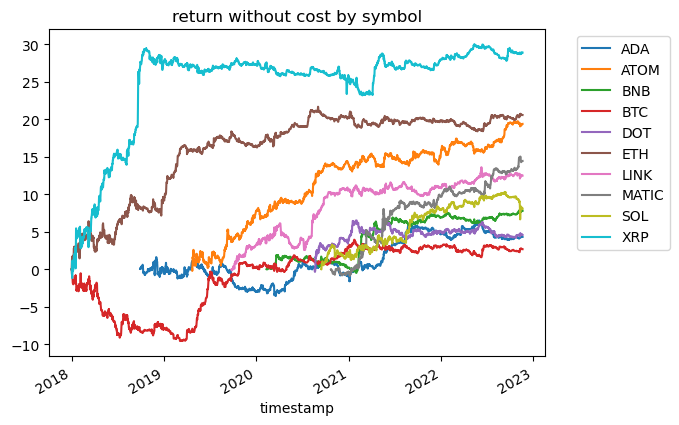

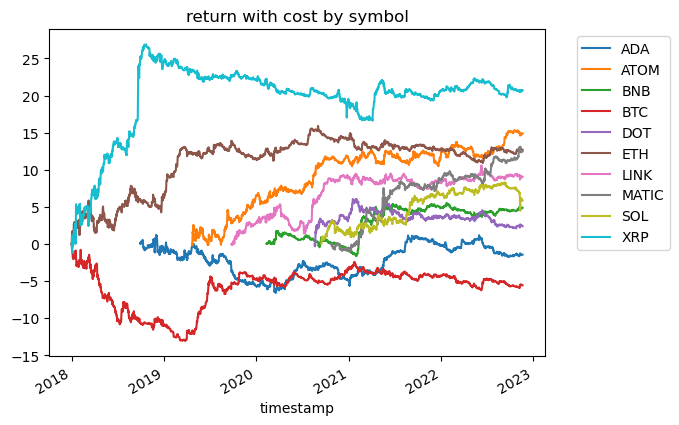

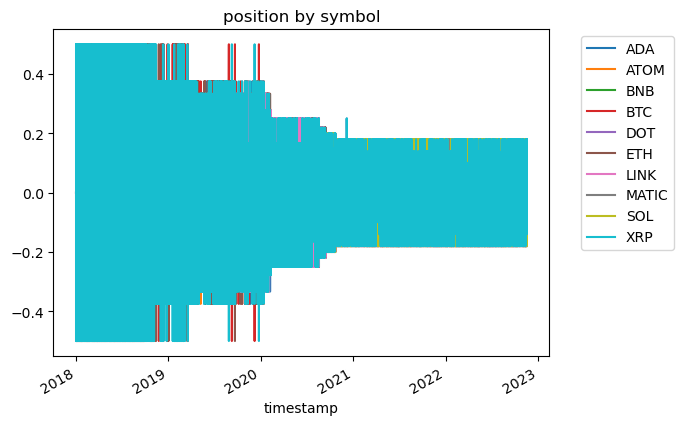

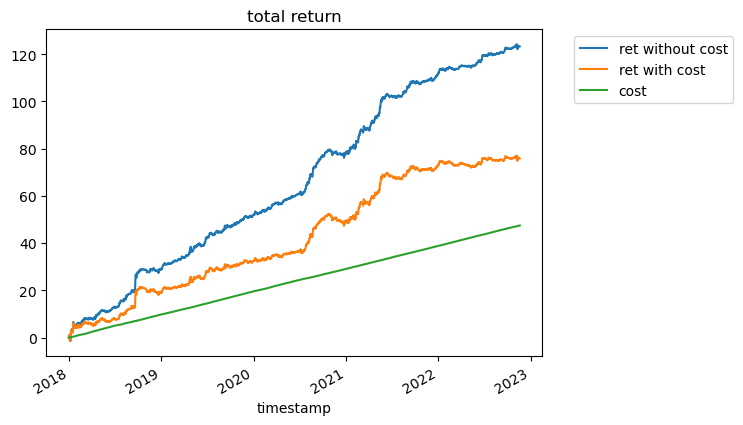

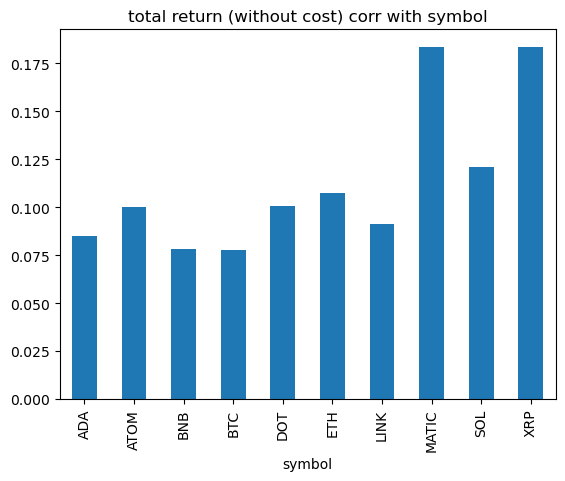

return without cost statistics
mean 0.0025338413317278763
std 0.016281246730303775
sharpe 0.15562944126457567
double sharpe 1.018319635164486
max drawdown 3.545175329800042
min -0.09715752839806835
min sharpe 0.02607972200925454
return with cost statistics
mean 0.001525606070855712
std 0.016283629826882286
sharpe 0.0936895573698883
double sharpe 0.46711744969609953
max drawdown 5.052870329800008
min -0.09843752839806835
min sharpe 0.015498215931289566


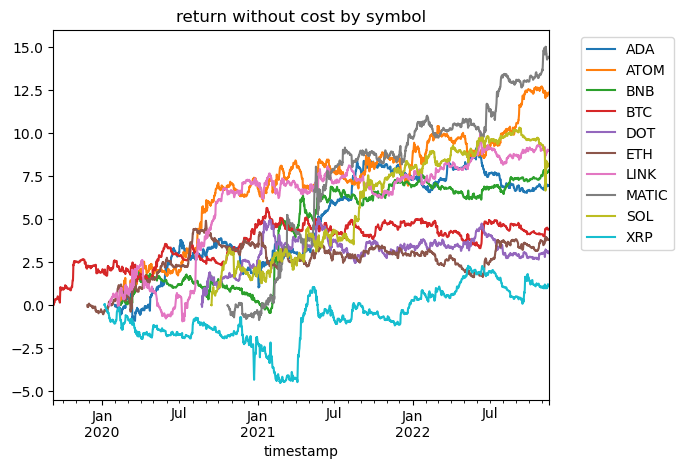

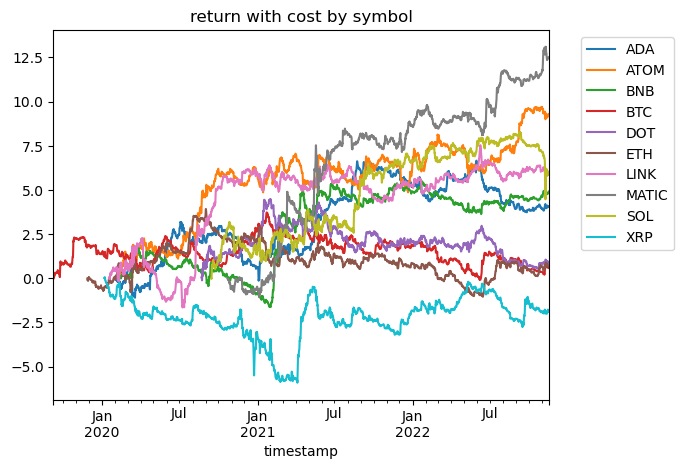

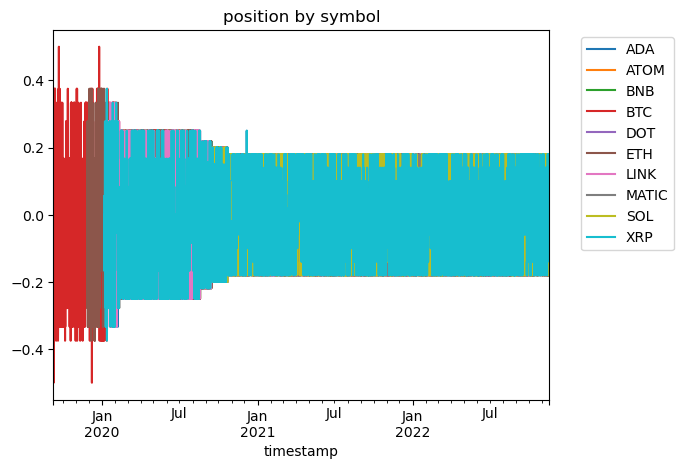

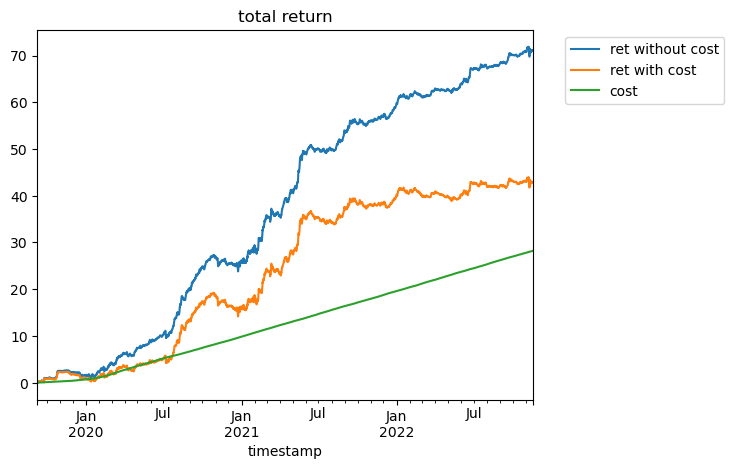

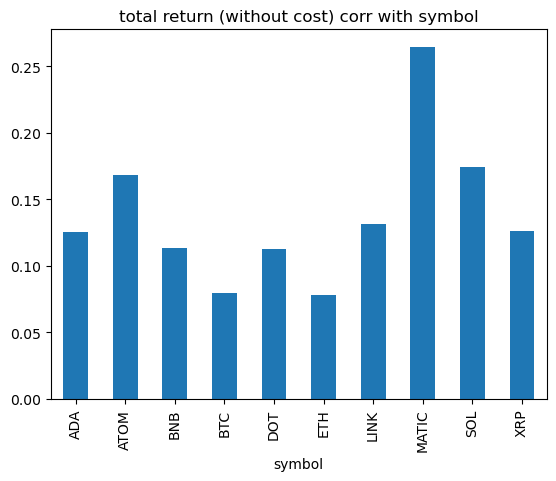

In [20]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-19 00:00:00Z')]
df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]
df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-25) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank()

# cv
calc_position_cv(model, df)
visualize_result(df.dropna())
visualize_result(df.loc[~df['extended']].dropna())
# visualize_result(df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2019-08-01 00:00:00Z')].dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220908_ranker.xz', 'wb') as f:
    f.write(data)

timestamp                  symbol
2022-11-12 18:00:00+00:00  ADA       0.00
                           ATOM      0.00
                           BNB       0.00
                           BTC       0.00
                           DOT       0.00
                                     ... 
2022-11-19 18:00:00+00:00  ETH       0.06
                           LINK     -0.02
                           MATIC    -0.06
                           SOL      -0.10
                           XRP       0.18
Name: position, Length: 1690, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


position1  position2  position3
timestamp                 symbol                                 
2022-11-12 19:00:00+00:00 ADA      0.125000   0.125000       0.00
                          ATOM    -0.083333  -0.083333       0.00
                          BNB     -0.083333  -0.083333       0.00
                          BTC      0.125000   0.125000       0.00
                          DOT      0.125000   0.125000       0.00
...                                     ...        ...        ...
2022-11-19 17:00:00+00:00 ETH      0.060000   0.060000       0.06
                          LINK    -0.020000  -0.020000      -0.02
                          MATIC   -0.140000  -0.140000      -0.14
                          SOL     -0.060000  -0.060000      -0.06
                          XRP      0.180000   0.180000       0.18

[1670 rows x 3 columns]

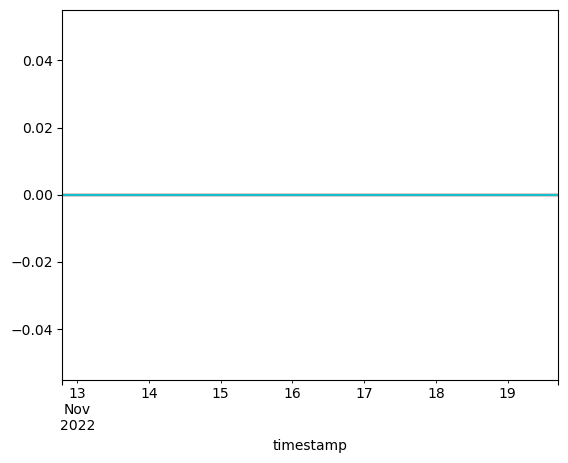

ADA (167, 4)
ATOM (167, 4)
BNB (167, 4)
BTC (167, 4)
DOT (167, 4)
ETH (167, 4)
LINK (167, 4)
MATIC (167, 4)
SOL (167, 4)
XRP (167, 4)


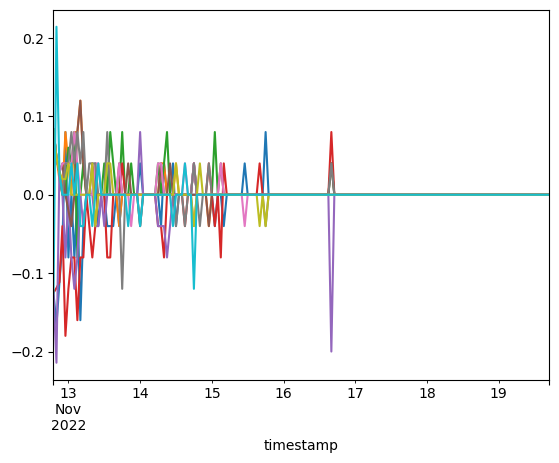

ADA (169, 3)
ATOM (169, 3)
BNB (169, 3)
BTC (169, 3)
DOT (169, 3)
ETH (169, 3)
LINK (169, 3)
MATIC (169, 3)
SOL (169, 3)
XRP (169, 3)


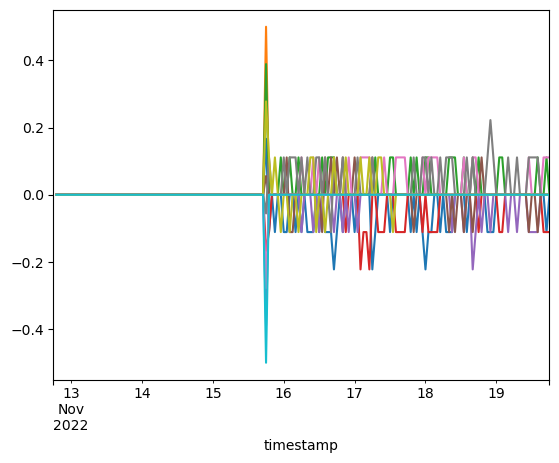

In [21]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220908_ranker.xz')
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

def _calc_features(df):        
    df = df.copy()

    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

    for col in get_feature_columns(df):
        df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

    return df

df_features1 = _calc_features(df)
df_features3 = _calc_features(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

df_test2 = pd.concat([
    df_features1['feature_rsi_72'].rename('feature1'),
    df_features3['feature_rsi_72'].rename('feature3'),
    # df_features1['feature_momentum_72'].rename('feature1'),
    # df_features3['feature_momentum_72'].rename('feature3'),
], axis=1)

for symbol, df_symbol in df_test2.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['feature3'] - df_symbol['feature1']).plot()
plt.show()